# Unsupervised Learning

The aim of this exercise is to introduce unsupervised learning in the form of data clustering. Clustering can be used to discover groups of data that share similar properties. For example, an online retailer may cluster customer purchases and detect customers with similar habits to form groups. This information can be used to find groups of customers that have similar interests and therefore may be interested in buying certain products. 

## Hierarchical Clustering 

In [1]:
### Begin of clustering utilities ###
### Yo *DO NOT* need to go through it ###
### Run this cell of code and keep moving ###

from PIL import Image, ImageDraw
from math import sqrt
import random
from urllib.request import urlopen


def readfile(url):
    lines = [line for line in urlopen(url)]

    # First line is the column titles
    colnames = lines[0].strip().decode('utf-8').split('\t')[1:]
    rownames = []
    data = []
    for line in lines[1:]:
        p = line.strip().decode('utf-8').split('\t')
    # First column in each row is the rowname
        rownames.append(p[0])
    # The data for this row is the remainder of the row
        data.append([float(x) for x in p[1:]])
    return (rownames, colnames, data)


def pearson(v1, v2):
  # Simple sums
    sum1 = sum(v1)
    sum2 = sum(v2)

  # Sums of the squares
    sum1Sq = sum([pow(v, 2) for v in v1])
    sum2Sq = sum([pow(v, 2) for v in v2])

    
  # Sum of the products
    pSum = sum([v1[i] * v2[i] for i in range(len(v1))])

  # Calculate r (Pearson score)
    num = pSum - sum1 * sum2 / len(v1)
    den = sqrt((sum1Sq - pow(sum1, 2) / len(v1)) * (sum2Sq - pow(sum2, 2)
               / len(v1)))
    if den == 0:
        return 0

    return 1.0 - num / den


class bicluster:

    def __init__(
        self,
        vec,
        left=None,
        right=None,
        distance=0.0,
        id=None,
        ):
        self.left = left
        self.right = right
        self.vec = vec
        self.id = id
        self.distance = distance


def hcluster(rows, distance=pearson):
    distances = {}
    currentclustid = -1
    print(len(rows))
  # Clusters are initially just the rows
    clust = [bicluster(rows[i], id=i) for i in range(len(rows))]

    while len(clust) > 1:
        lowestpair = (0, 1)
        closest = distance(clust[0].vec, clust[1].vec)

    # loop through every pair looking for the smallest distance
        for i in range(len(clust)):
            for j in range(i + 1, len(clust)):
        # distances is the cache of distance calculations
                if (clust[i].id, clust[j].id) not in distances:
                    distances[(clust[i].id, clust[j].id)] = \
                        distance(clust[i].vec, clust[j].vec)

                d = distances[(clust[i].id, clust[j].id)]

                if d < closest:
                    closest = d
                    lowestpair = (i, j)

    # calculate the average of the two clusters
        mergevec = [(clust[lowestpair[0]].vec[i] + clust[lowestpair[1]].vec[i])
                    / 2.0 for i in range(len(clust[0].vec))]

    # create the new cluster
        newcluster = bicluster(mergevec, left=clust[lowestpair[0]],
                               right=clust[lowestpair[1]], distance=closest,
                               id=currentclustid)

    # cluster ids that weren't in the original set are negative
        currentclustid -= 1
        del clust[lowestpair[1]]
        del clust[lowestpair[0]]
        clust.append(newcluster)

    return clust[0]


def printclust(clust, labels=None, n=0):
  # indent to make a hierarchy layout
    for i in range(n):
        print(' '),
    if clust.id < 0:
    # negative id means that this is branch
        print('-')
    else:
    # positive id means that this is an endpoint
        if labels == None:
            print(clust.id)
        else:
            print(labels[clust.id])

  # now print the right and left branches
    if clust.left != None:
        printclust(clust.left, labels=labels, n=n + 1)
    if clust.right != None:
        printclust(clust.right, labels=labels, n=n + 1)


def getheight(clust):
  # Is this an endpoint? Then the height is just 1
    if clust.left == None and clust.right == None:
        return 1

  # Otherwise the height is the same of the heights of
  # each branch
    return getheight(clust.left) + getheight(clust.right)


def getdepth(clust):
  # The distance of an endpoint is 0.0
    if clust.left == None and clust.right == None:
        return 0

  # The distance of a branch is the greater of its two sides
  # plus its own distance
    return max(getdepth(clust.left), getdepth(clust.right)) + clust.distance


def drawdendrogram(clust, labels):
  # height and width
    h = getheight(clust) * 20
    w = 1200
    depth = getdepth(clust)

  # width is fixed, so scale distances accordingly
    scaling = float(w - 150) / depth

  # Create a new image with a white background
    img = Image.new('RGB', (w, h), (255, 255, 255))
    draw = ImageDraw.Draw(img)

    draw.line((0, h / 2, 10, h / 2), fill=(255, 0, 0))

  # Draw the first node
    drawnode(
        draw,
        clust,
        10,
        h / 2,
        scaling,
        labels,
        )
    #img.save(jpeg, 'JPEG')
    return img

def drawnode(
    draw,
    clust,
    x,
    y,
    scaling,
    labels,
    ):
    if clust.id < 0:
        h1 = getheight(clust.left) * 20
        h2 = getheight(clust.right) * 20
        top = y - (h1 + h2) / 2
        bottom = y + (h1 + h2) / 2
    # Line length
        ll = clust.distance * scaling
    # Vertical line from this cluster to children
        draw.line((x, top + h1 / 2, x, bottom - h2 / 2), fill=(255, 0, 0))

    # Horizontal line to left item
        draw.line((x, top + h1 / 2, x + ll, top + h1 / 2), fill=(255, 0, 0))

    # Horizontal line to right item
        draw.line((x, bottom - h2 / 2, x + ll, bottom - h2 / 2), fill=(255, 0,
                  0))

    # Call the function to draw the left and right nodes
        drawnode(
            draw,
            clust.left,
            x + ll,
            top + h1 / 2,
            scaling,
            labels,
            )
        drawnode(
            draw,
            clust.right,
            x + ll,
            bottom - h2 / 2,
            scaling,
            labels,
            )
    else:
    # If this is an endpoint, draw the item label
        draw.text((x + 5, y - 7), labels[clust.id], (0, 0, 0))


def rotatematrix(data):
    newdata = []
    for i in range(len(data[0])):
        newrow = [data[j][i] for j in range(len(data))]
        newdata.append(newrow)
    return newdata


def kcluster(rows, distance=pearson, k=4):
  # Determine the minimum and maximum values for each point
    ranges = [(min([row[i] for row in rows]), max([row[i] for row in rows]))
              for i in range(len(rows[0]))]

  # Create k randomly placed centroids
    clusters = [[random.random() * (ranges[i][1] - ranges[i][0]) + ranges[i][0]
                for i in range(len(rows[0]))] for j in range(k)]

    lastmatches = None
    for t in range(100):
        print('Iteration %d' % t)
        bestmatches = [[] for i in range(k)]

    # Find which centroid is the closest for each row
        for j in range(len(rows)):
            row = rows[j]
            bestmatch = 0
            for i in range(k):
                d = distance(clusters[i], row)
                if d < distance(clusters[bestmatch], row):
                    bestmatch = i
            bestmatches[bestmatch].append(j)

    # If the results are the same as last time, this is complete
        if bestmatches == lastmatches:
            break
        lastmatches = bestmatches

    # Move the centroids to the average of their members
        for i in range(k):
            avgs = [0.0] * len(rows[0])
            if len(bestmatches[i]) > 0:
                for rowid in bestmatches[i]:
                    for m in range(len(rows[rowid])):
                        avgs[m] += rows[rowid][m]
                for j in range(len(avgs)):
                    avgs[j] /= len(bestmatches[i])
                clusters[i] = avgs

    return bestmatches


def tanamoto(v1, v2):
    (c1, c2, shr) = (0, 0, 0)

    for i in range(len(v1)):
        if v1[i] != 0:  # in v1
            c1 += 1
        if v2[i] != 0:  # in v2
            c2 += 1
        if v1[i] != 0 and v2[i] != 0:  # in both
            shr += 1

    return 1.0 - float(shr) / (c1 + c2 - shr)


def scaledown(data, distance=pearson, rate=0.01):
    n = len(data)

  # The real distances between every pair of items
    realdist = [[distance(data[i], data[j]) for j in range(n)] for i in
                range(0, n)]

  # Randomly initialize the starting points of the locations in 2D
    loc = [[random.random(), random.random()] for i in range(n)]
    fakedist = [[0.0 for j in range(n)] for i in range(n)]

    lasterror = None
    for m in range(0, 1000):
    # Find projected distances
        for i in range(n):
            for j in range(n):
                fakedist[i][j] = sqrt(sum([pow(loc[i][x] - loc[j][x], 2)
                                      for x in range(len(loc[i]))]))

    # Move points
        grad = [[0.0, 0.0] for i in range(n)]

        totalerror = 0
        for k in range(n):
            for j in range(n):
                if j == k:
                    continue
        # The error is percent difference between the distances
                errorterm = (fakedist[j][k] - realdist[j][k]) / realdist[j][k]

        # Each point needs to be moved away from or towards the other
        # point in proportion to how much error it has
                grad[k][0] += (loc[k][0] - loc[j][0]) / fakedist[j][k] \
                    * errorterm
                grad[k][1] += (loc[k][1] - loc[j][1]) / fakedist[j][k] \
                    * errorterm

        # Keep track of the total error
                totalerror += abs(errorterm)
        print(totalerror)

    # If the answer got worse by moving the points, we are done
        if lasterror and lasterror < totalerror:
            break
        lasterror = totalerror

    # Move each of the points by the learning rate times the gradient
        for k in range(n):
            loc[k][0] -= rate * grad[k][0]
            loc[k][1] -= rate * grad[k][1]

    return loc


def draw2d(data, labels, jpeg='mds2d.jpg'):
    img = Image.new('RGB', (2000, 2000), (255, 255, 255))
    draw = ImageDraw.Draw(img)
    for i in range(len(data)):
        x = (data[i][0] + 0.5) * 1000
        y = (data[i][1] + 0.5) * 1000
        draw.text((x, y), labels[i], (0, 0, 0))
    img.save(jpeg, 'JPEG')
    
### End of clustering utilities ###

In this exercise, we will cluster the text information in blogs to determine their content groups. We will use the textual data from a list of Web blogs and the information will be gathered from their associated RSS feeds. The RSS feeds will be parsed using Universal Feed Parser (<http://www.feedparser.org/>).

If you open **blogdata.txt** you will see that it contains the title of each blog and their associated words and frequencies. We can now use this information to discover clusters.

In [2]:
blognames,words,data = readfile('https://raw.githubusercontent.com/wOOL/COM2028/master/W3/blogdata.txt')
clust = hcluster(data)
printclust(clust,labels=blognames)

70
-
 
-
 
 
MichelleMalkin.com
 
 
We Make Money Not Art
 
-
 
 
Gigaom
 
 
-
 
 
 
pharyngula
 
 
 
-
 
 
 
 
-
 
 
 
 
 
O'Reilly Radar
 
 
 
 
 
-
 
 
 
 
 
 
PaulStamatiou.com - Technology, Design and Photography
 
 
 
 
 
 
Celebslam
 
 
 
 
-
 
 
 
 
 
-
 
 
 
 
 
 
ShoeMoney
 
 
 
 
 
 
-
 
 
 
 
 
 
 
Creating Passionate Users
 
 
 
 
 
 
 
-
 
 
 
 
 
 
 
 
Joi Ito's Web
 
 
 
 
 
 
 
 
-
 
 
 
 
 
 
 
 
 
-
 
 
 
 
 
 
 
 
 
 
BuzzMachine
 
 
 
 
 
 
 
 
 
 
-
 
 
 
 
 
 
 
 
 
 
 
Guy Kawasaki
 
 
 
 
 
 
 
 
 
 
 
-
 
 
 
 
 
 
 
 
 
 
 
 
ReadWrite
 
 
 
 
 
 
 
 
 
 
 
 
-
 
 
 
 
 
 
 
 
 
 
 
 
 
Copyblogger
 
 
 
 
 
 
 
 
 
 
 
 
 
-
 
 
 
 
 
 
 
 
 
 
 
 
 
 
ProBlogger
 
 
 
 
 
 
 
 
 
 
 
 
 
 
Gapingvoid
 
 
 
 
 
 
 
 
 
-
 
 
 
 
 
 
 
 
 
 
-
 
 
 
 
 
 
 
 
 
 
 
Make: DIY Projects and Ideas for Makers
 
 
 
 
 
 
 
 
 
 
 
-
 
 
 
 
 
 
 
 
 
 
 
 
Seth Godin's Blog on marketing, tribes and respect
 
 
 
 
 
 
 
 
 
 
 
 
-
 
 
 
 
 
 
 
 
 
 
 
 
 
Autobl

This runs hierarchical clustering. It may take a few minutes to run as it calculates all of the distances. To view the results of the hierarchical clustering we will use the printclust function in **clusters.py**. Run the code and you will see that it simply displays the clustering tree in a similar fashion to a file structure. Can you see anything interesting? Can you notice some similarities between blogs?

The output presented above provided some interesting results, however, these were probably quite difficult to read and interpret. In the next step, we will create a dendrogram to display the results more clearly.

Hierarchical clustering results are normally viewed in a dendrogram. They can provide a lot of information in a small space. To create the dendrogram, we will be using the Python Imaging Library.


In [3]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

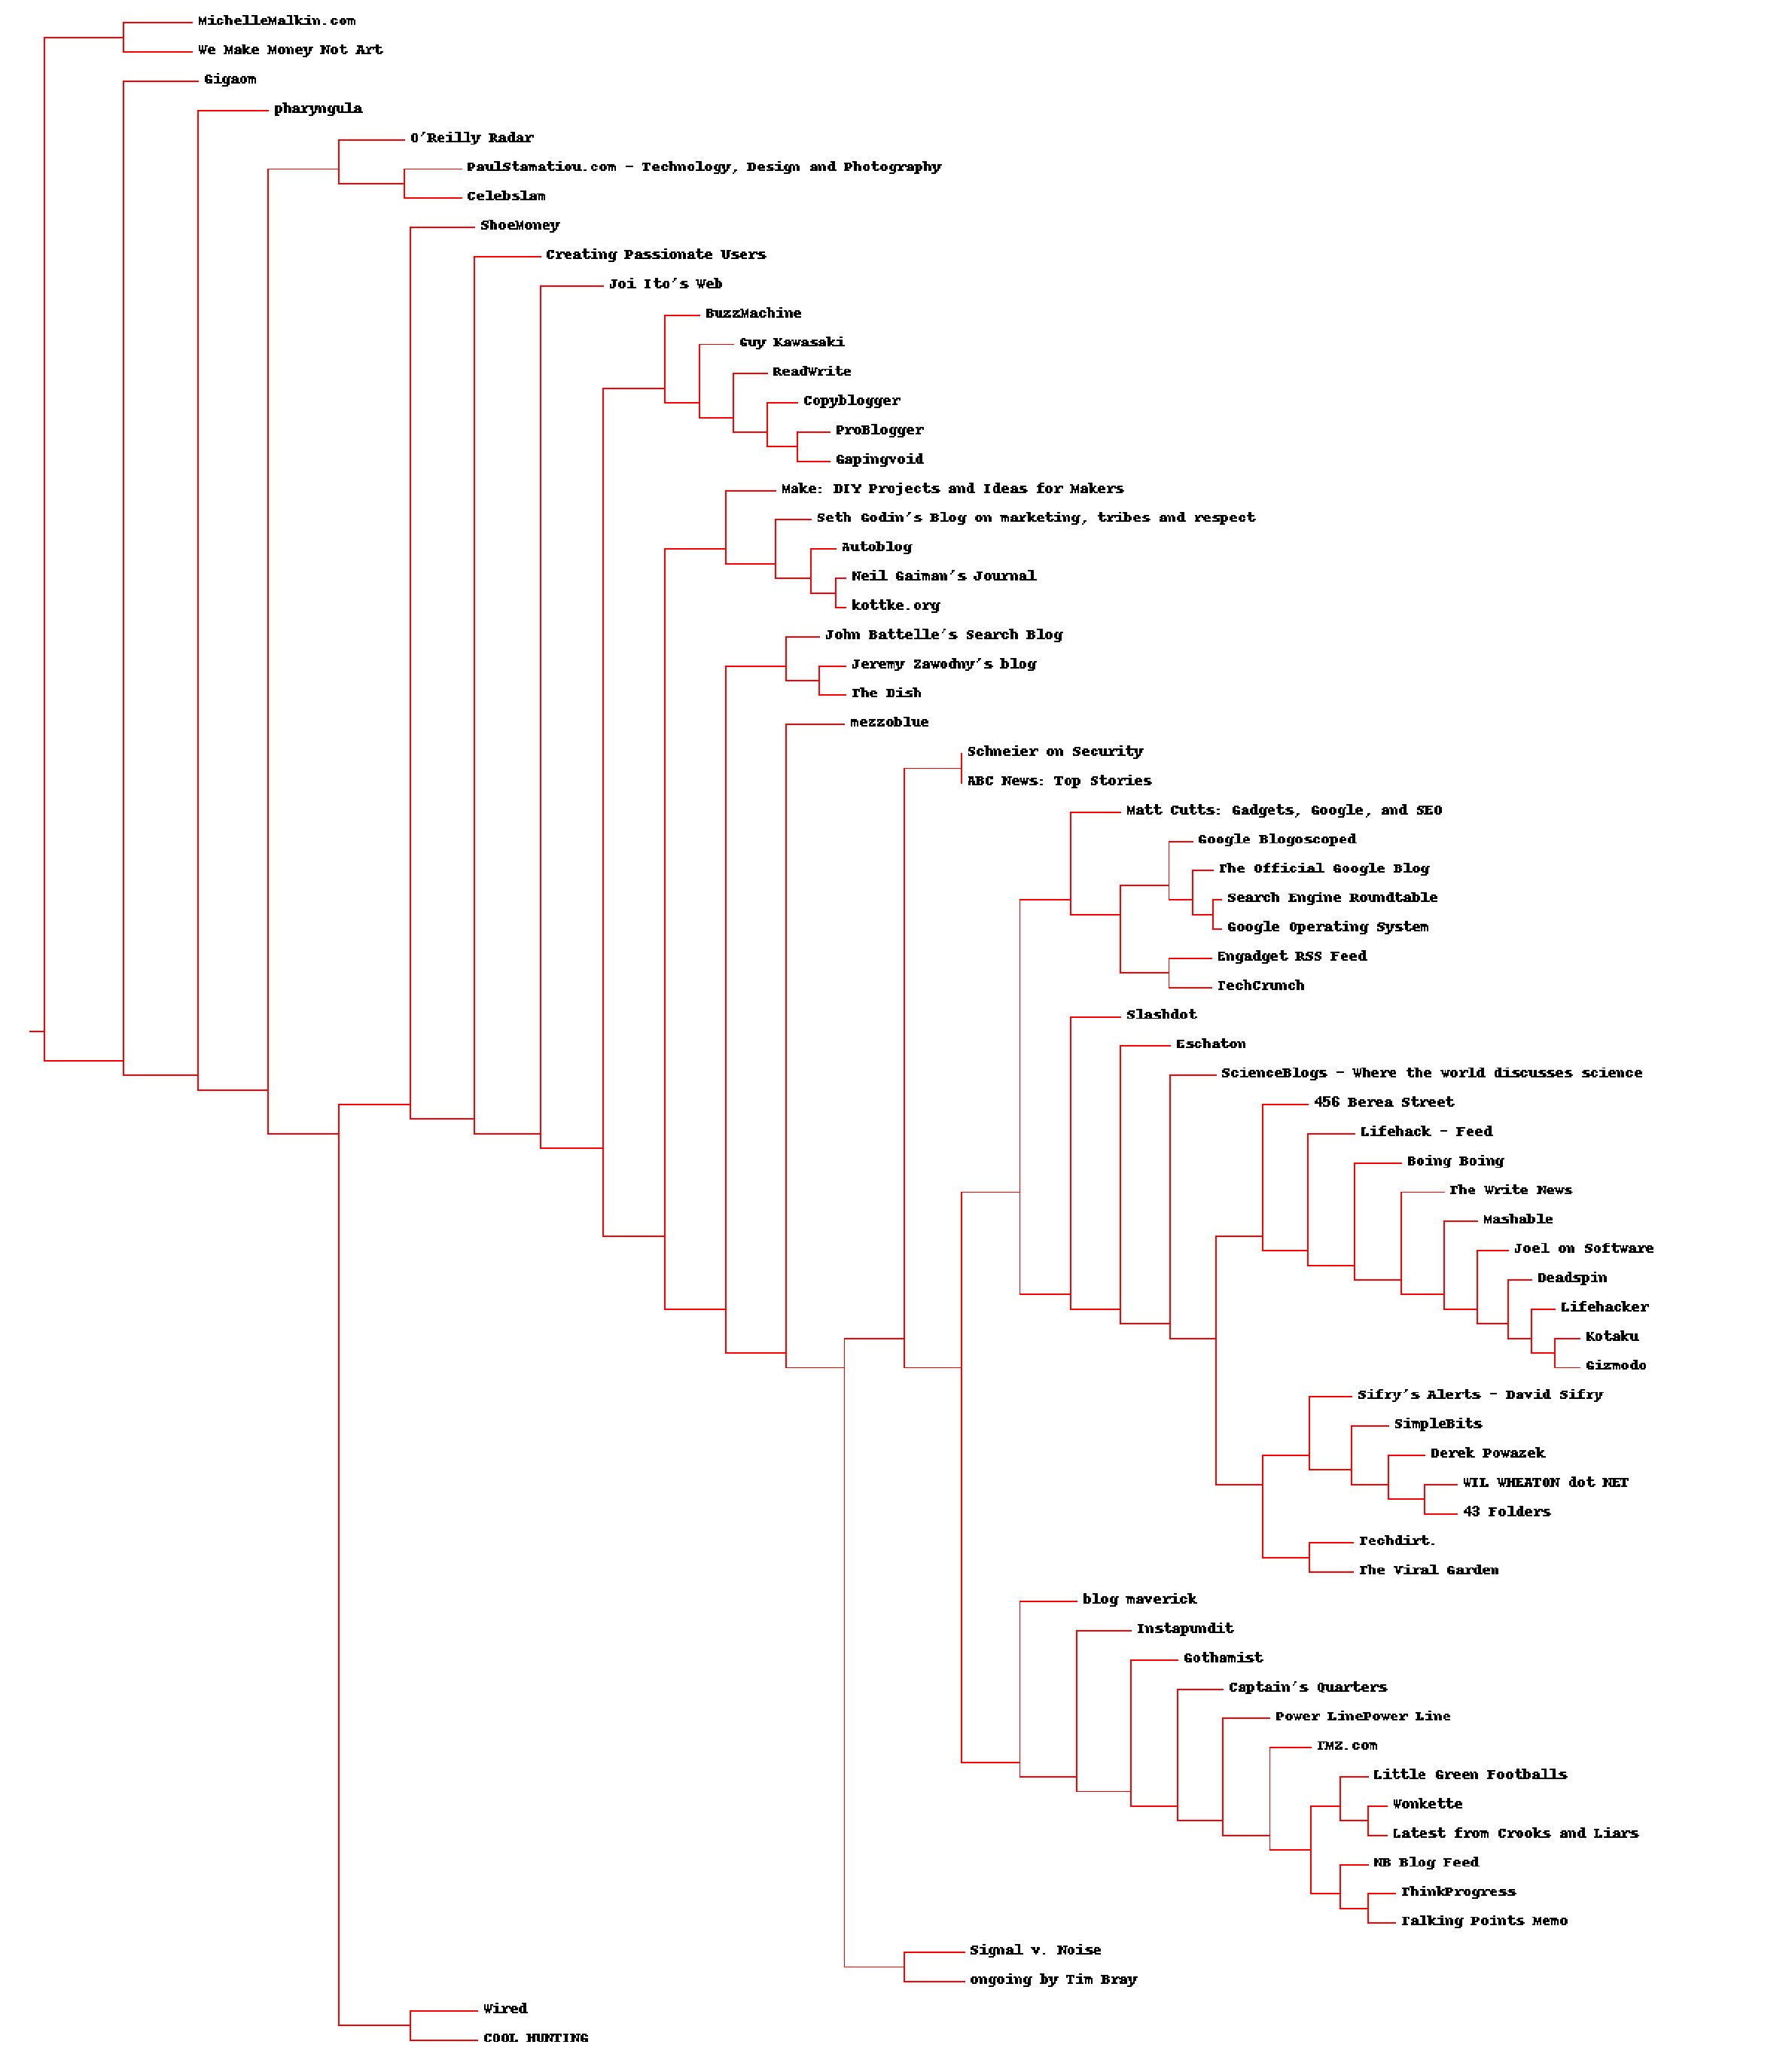

In [4]:
img = drawdendrogram(clust, blognames)
plt.rcParams['figure.figsize'] = [100, 50]
plt.imshow(img)
plt.axis("off")
plt.show()

Congratulations! You just created dendrogram of your blog data! Examine your image and you should find some interesting information in there. Try and find some of the blogs that you entered at the end of ‘feedlist.txt’ – there may be some similar blogs that you might be interested in?

It is often useful to cluster on both columns and rows. In a marketing study, you may want to group people to find demographics and products for example. With our blog dataset, the columns represent words – it could be interesting to group words and see which words are commonly used together.

Similar to the program you developed in the previous labsheet, we can simply rotate the dataset so that the columns become rows. This will result in the rows representing words, each with a list of numbers indicating their frequency in each blog. In clusters.py examine the function rotatematrix, which does this for us.

530


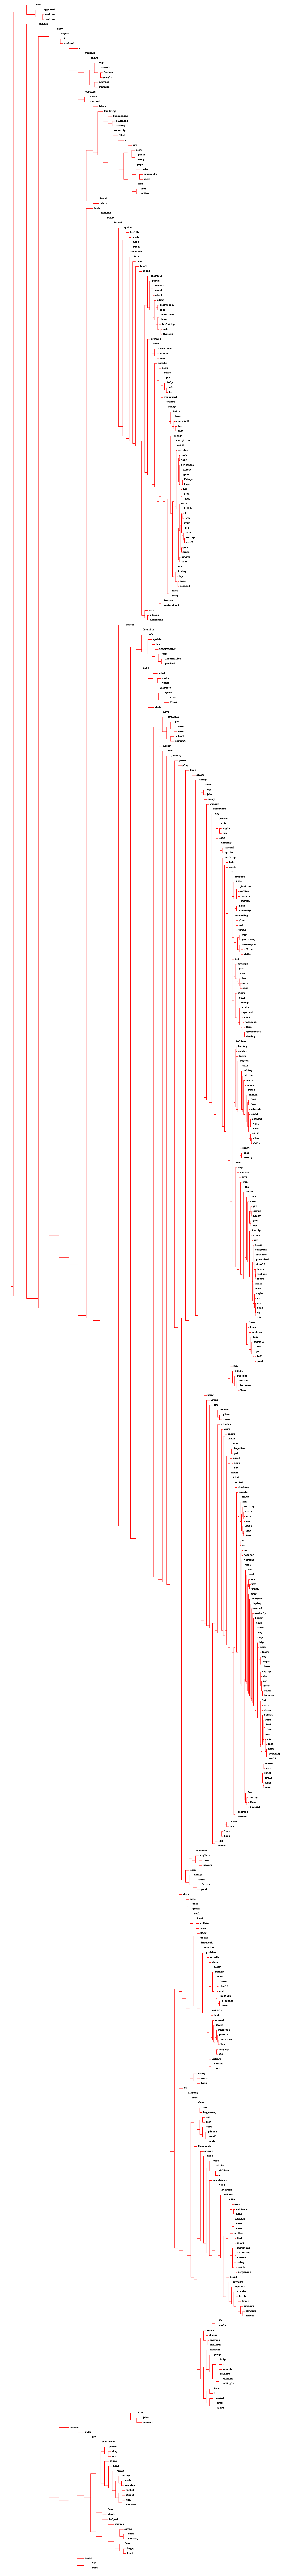

In [5]:
rdata = rotatematrix(data)
wordclust = hcluster(rdata)
img = drawdendrogram(wordclust, labels=words)
plt.rcParams['figure.figsize'] = [400, 200]
plt.imshow(img)
plt.axis("off")
plt.show()

With the data rotated to its new form, do you think that the clustering will take a shorter or longer time to complete? Do you expect the resulting dendrogram to be larger or smaller? Why? 

Analyse its content and you should hopefully find some interesting clusters in there. You will probably also see that there are many clusters in there that do not make too much sense. There are likely to be more nonsensical clusters in the second dendrogram - Can you think of a reason?

![Figure1](https://raw.githubusercontent.com/wOOL/COM2028/master/W3/dendrogram.png)


Some clusters in the second dendrogram may be nonsensical.

Hierarchical clustering produces useful tree diagrams but there are disadvantages with this method. The algorithm is computationally expensive and has exponential growth (do you think Amazon would be able to run hierarchical clustering with their immense amount of data?). It is also relatively difficult to break the data into distinct groups.

An alternative method is K-Means clustering. With this method, it is told in advance how many distinct clusters to generate. The algorithm determines the size of the clusters based on the structure of the data.


## K-Means clustering
K-Means clustering begins with k randomly distributed centroids and assigns each item to the nearest one forming temporary individual groups (clusters). After the assignment, the centroids are moved to the average location of all the nodes assigned to them, and the assignment process repeats again. The algorithm stops until no item changes its group during the assignment process and the final clusters are obtained.

![Figure1](https://raw.githubusercontent.com/wOOL/COM2028/master/W3/K-Means.png)
K-Means clustering with two clusters (Segaran, T. ‘Programming Collective Intelligence’, p43)

First, let's generate a two-dimensional dataset containing four distinct blobs. To emphasize that this is an unsupervised algorithm, we will leave the labels out of the visualisation

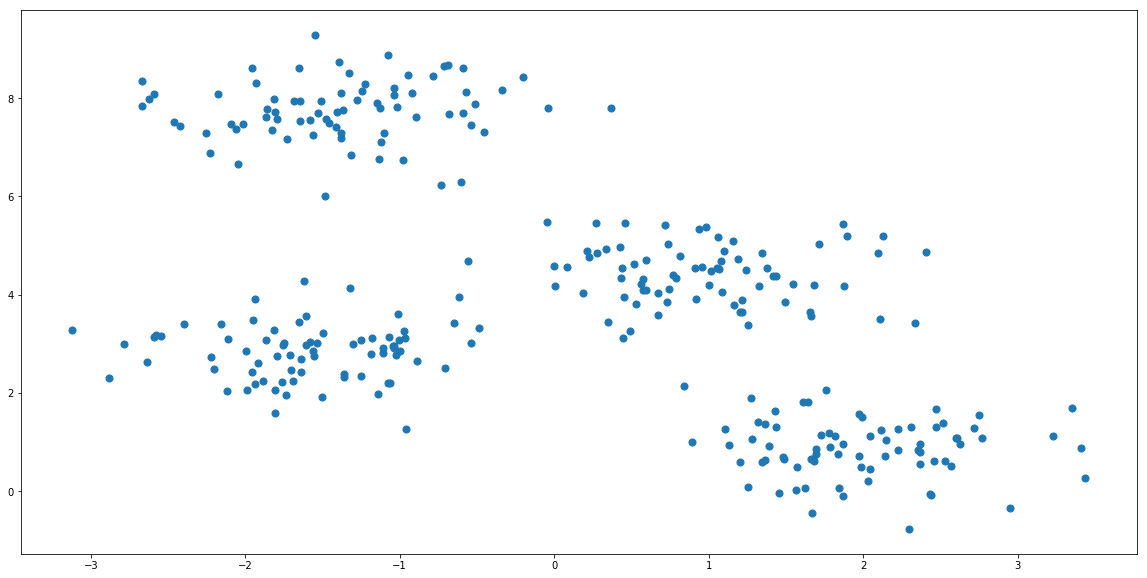

In [6]:
from sklearn.datasets.samples_generator import make_blobs
plt.rcParams['figure.figsize'] = [20, 10]

X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)

plt.scatter(X[:, 0], X[:, 1], s=50);

By eye, it is relatively easy to pick out the four clusters. The k-means algorithm does this automatically, and in Scikit-Learn uses the typical estimator API:

In [7]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

Let's visualise the results by plotting the data colored by these labels. We will also plot the cluster centers as determined by the k-means estimator:

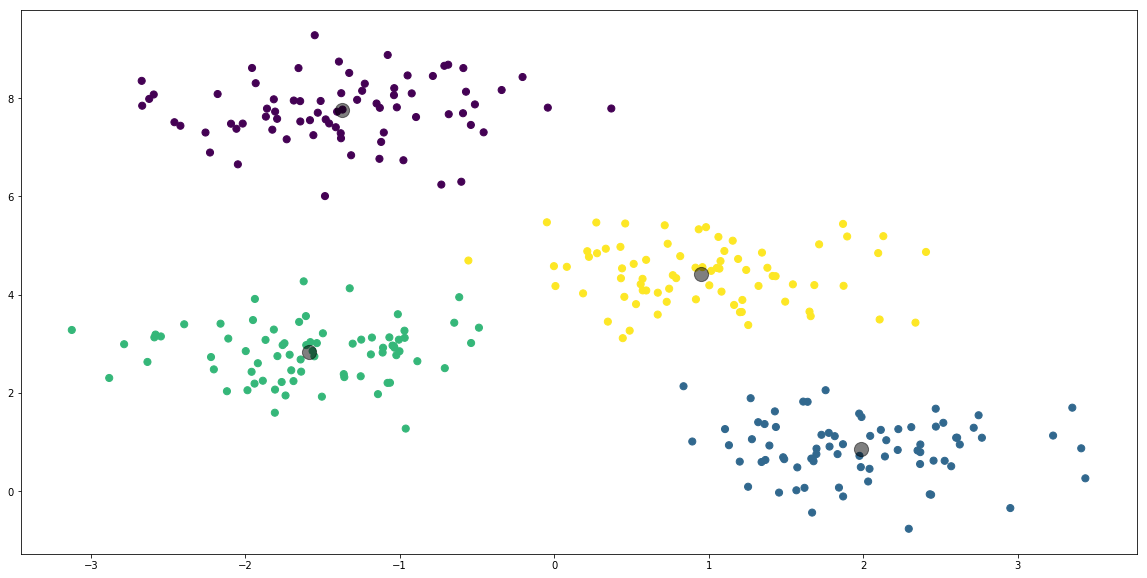

In [8]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

The common challenge of k-means is that you must tell it how many clusters you expect: it cannot learn the number of clusters from the data. For example, if we ask the algorithm to identify six clusters, it will happily proceed and find the best six clusters:

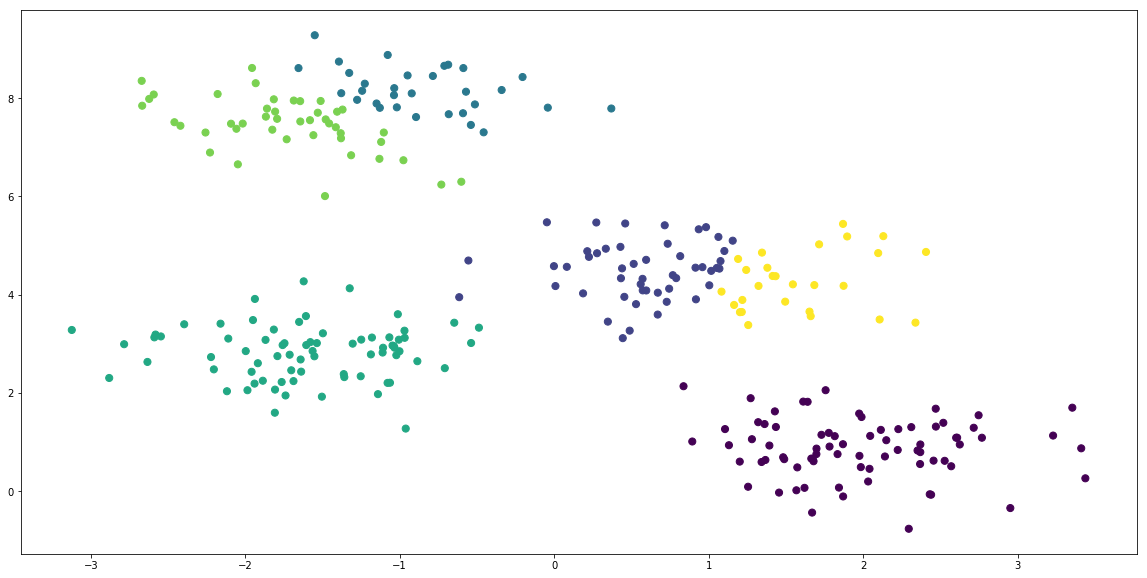

In [9]:
labels = KMeans(6, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

Another common challenge of k-means is that k-means can be slow for large numbers of samples. Because each iteration of k-means must access every point in the dataset, the algorithm can be relatively slow as the number of samples grows. You might wonder if this requirement to use all data at each iteration can be relaxed; for example, you might just use a subset of the data to update the cluster centers at each step. This is the idea behind batch-based k-means algorithms, one form of which is implemented in sklearn.cluster.MiniBatchKMeans. The interface for this is the same as for standard KMeans; we will see an example of its use as we continue our discussion.

One interesting application of clustering is in color compression within images. For example, imagine you have an image with millions of colors. In most images, a large number of the colors will be unused, and many of the pixels in the image will have similar or even identical colors.

For example, consider the image shown in the following figure, which is from the Scikit-Learn datasets module (for this to work, you'll have to have the pillow Python package installed).



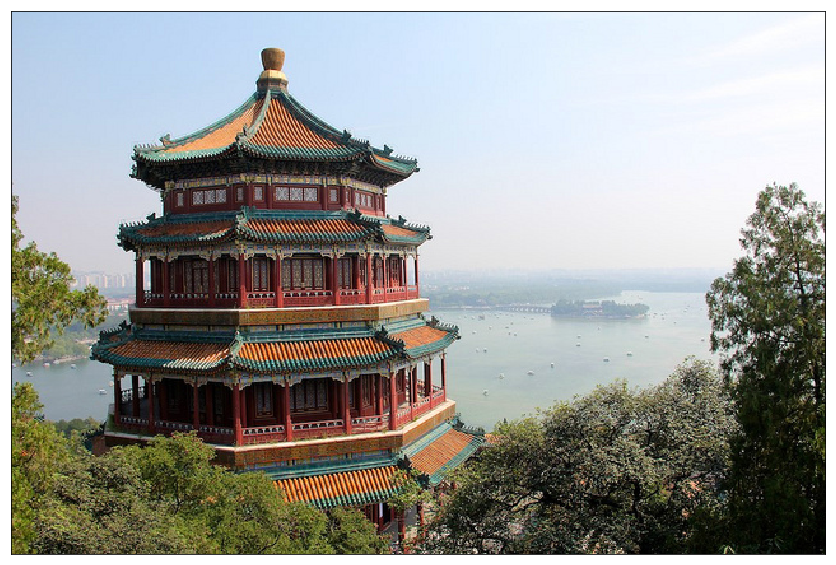

In [10]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china);

The image itself is stored in a three-dimensional array of size (height, width, RGB), containing red/blue/green contributions as integers from 0 to 255:

In [11]:
china.shape

(427, 640, 3)

One way we can view this set of pixels is as a cloud of points in a three-dimensional color space. We will reshape the data to [n_samples x n_features], and rescale the colors so that they lie between 0 and 1:

In [12]:
data = china / 255.0 # use 0...1 scale
data = data.reshape(427 * 640, 3)
data.shape

(273280, 3)

We can visualize these pixels in this color space, using a subset of 10,000 pixels for efficiency:

In [13]:
import numpy as np
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);

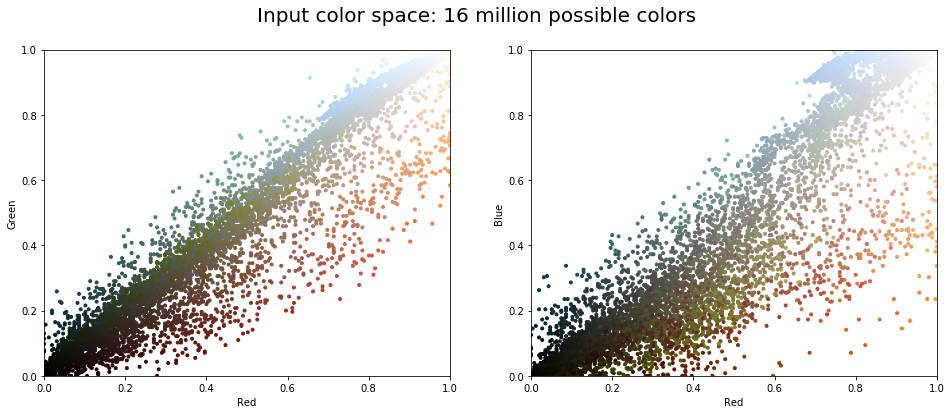

In [14]:
plot_pixels(data, title='Input color space: 16 million possible colors')

Now let's reduce these 16 million colors to just 16 colors, using a k-means clustering across the pixel space. Because we are dealing with a very large dataset, we will use the mini batch k-means, which operates on subsets of the data to compute the result much more quickly than the standard k-means algorithm:

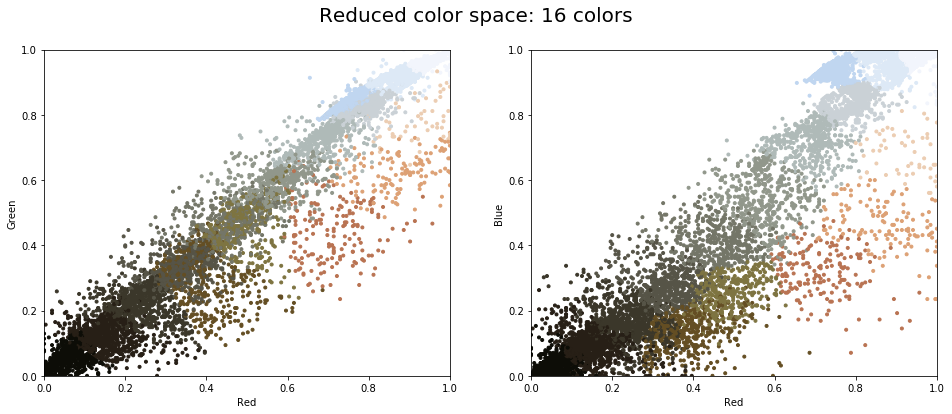

In [15]:
import warnings; warnings.simplefilter('ignore') 

from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors=new_colors,
            title="Reduced color space: 16 colors")

The result is a re-coloring of the original pixels, where each pixel is assigned the color of its closest cluster center. Plotting these new colors in the image space rather than the pixel space shows us the effect of this:

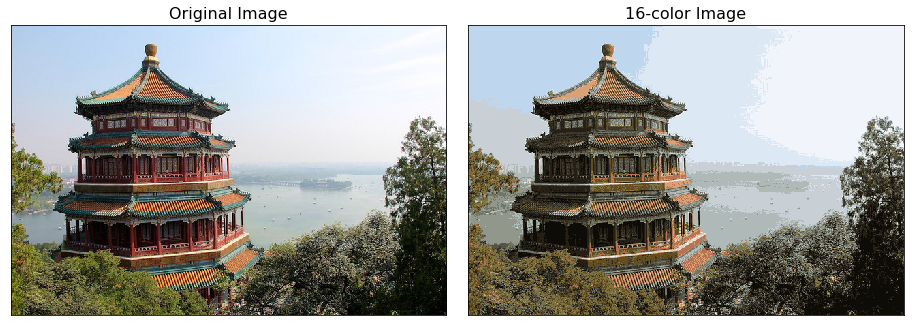

In [16]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image', size=16);

Some detail is certainly lost in the rightmost panel, but the overall image is still easily recognizable. This image on the right achieves a compression factor of around 1 million!

## Exercises

**Task 1**: Try to use the different clusters of Kmeans for the colour compression sample and then demonstrate the effect of them.

**Task 2**: Try to use your own images for the colour compression and then demonstrate the effect of this. (Hint: to use PIL.Image function to load images from files)

**Task 3**: Let's take a look at applying k-means on the simple digits data. Here we will attempt to use k-means to try to identify similar digits without using the original label information; this might be similar to a first step in extracting meaning from a new dataset about which you don't have any a priori label information.

We will start by loading the digits and then finding the KMeans clusters. Recall that the digits consist of 1,797 samples with 64 features, where each of the 64 features is the brightness of one pixel in an 8×8 image. The following codes are hints. 

In [17]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

The clustering can be performed as we did before:

In [22]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

The result is 10 clusters in 64 dimensions. Notice that the cluster centers themselves are 64-dimensional points, and can themselves be interpreted as the "typical" digit within the cluster. Let's see what these cluster centers look like:

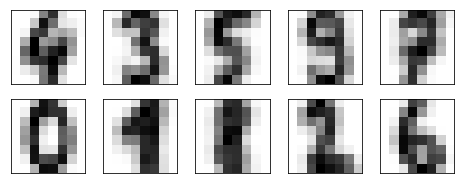

In [23]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

Because k-means knows nothing about the identity of the cluster, the 0–9 labels may be permuted. We can fix this by matching each learned cluster label with the true labels found in them:

In [24]:
from scipy.stats import mode
import numpy as np

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

Now we can check how accurate our unsupervised clustering was in finding similar digits within the data:

In [25]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [26]:
accuracy_score(digits.target, labels)

0.7935447968836951

With just a simple k-means algorithm, we discovered the correct grouping for 80% of the input digits! Let's check the confusion matrix for this:

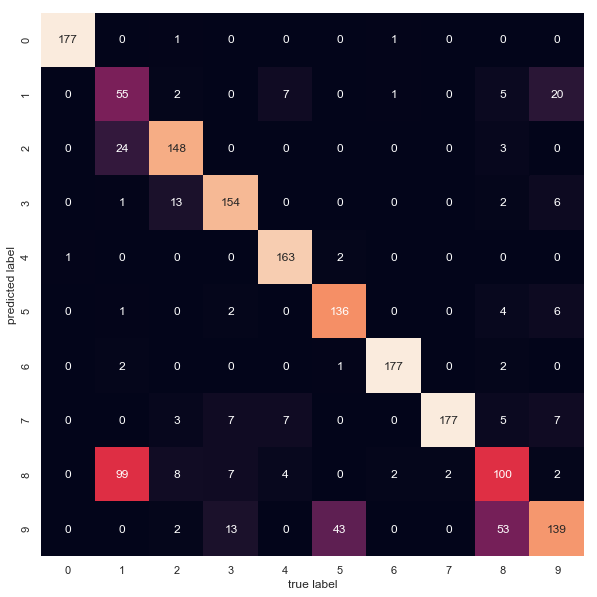

In [27]:
import seaborn as sns; sns.set()  # for plot styling
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

As we might expect from the cluster centers we visualized before, the main point of confusion is between the eights and ones. But this still shows that using k-means, we can essentially build a digit classifier without reference to any known labels!